---

Vamos a prácticar el KNN para ello  vamos a necesitar las siguientes librerías:

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches
import seaborn as sb
import statsmodels.api as sm
import imblearn
from imblearn.over_sampling import SMOTE

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Preprocesado y modelado KNN
from sklearn.neighbors import KNeighborsClassifier

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings('once')

 ### Leemos nuestro archivo de entrada

In [4]:
dataframe = pd.read_csv(r"reviews_sentiment.csv",sep=';')
dataframe.head(15)


,Review Title,Review Text,wordcount,titleSentiment,textSentiment,Star Rating,sentimentValue
0,Sin conexión,Hola desde hace algo más de un mes me pone sin...,23,negative,negative,1,-0.486389
1,faltan cosas,Han mejorado la apariencia pero no,20,negative,negative,1,-0.586187
2,Es muy buena lo recomiendo,Andres e puto amoooo,4,NaN,negative,1,-0.602240
3,Version antigua,Me gustana mas la version anterior esta es mas...,17,NaN,negative,1,-0.616271
4,Esta bien,Sin ser la biblia.... Esta bien,6,negative,negative,1,-0.651784
5,Buena,Nada del otro mundo pero han mejorado mucho,8,positive,negative,1,-0.720443
6,De gran ayuda,"Lo malo q necesita de …,pero la app es muy buena",23,positive,negative,1,-0.726825
7,Muy buena,"Estaba más acostumbrado al otro diseño, pero e...",16,positive,negative,1,-0.736769
8,Ta to guapa.,Va de escándalo,21,positive,negative,1,-0.765284
9,Se han corregido,Han corregido muchos fallos pero el diseño es ...,13,negative,negative,1,-0.797961


In [5]:
# Describimos nuestros datos para ver cómo se distribuyen los datos
dataframe.describe()

,wordcount,Star Rating,sentimentValue
count,257.000000,257.000000,257.000000
mean,11.501946,3.420233,0.383849
std,13.159812,1.409531,0.897987
min,1.000000,1.000000,-2.276469
25%,3.000000,3.000000,-0.108144
50%,7.000000,3.000000,0.264091
75%,16.000000,5.000000,0.808384
max,103.000000,5.000000,3.264579


In [6]:
dataframe.loc[:, 'Star Rating']

0      1
1      1
2      1
3      1
4      1
      ..
252    5
253    5
254    5
255    5
256    5
Name: Star Rating, Length: 257, dtype: int64

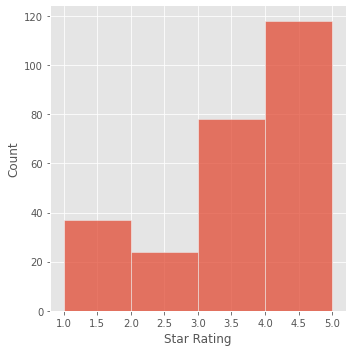

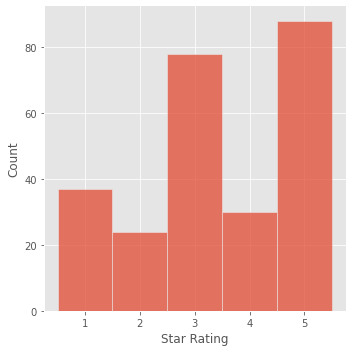

In [7]:
sb.displot(dataframe, x="Star Rating", bins=[1, 2, 3, 4, 5])
sb.displot(dataframe, x="Star Rating", discrete=True)

### EDA Básico

En seaborn podemos utilizar FacetGrid y realizar el gráfico como un [factorplot](https://www.emilkhatib.es/representaciones-graficas-con-seaborn)

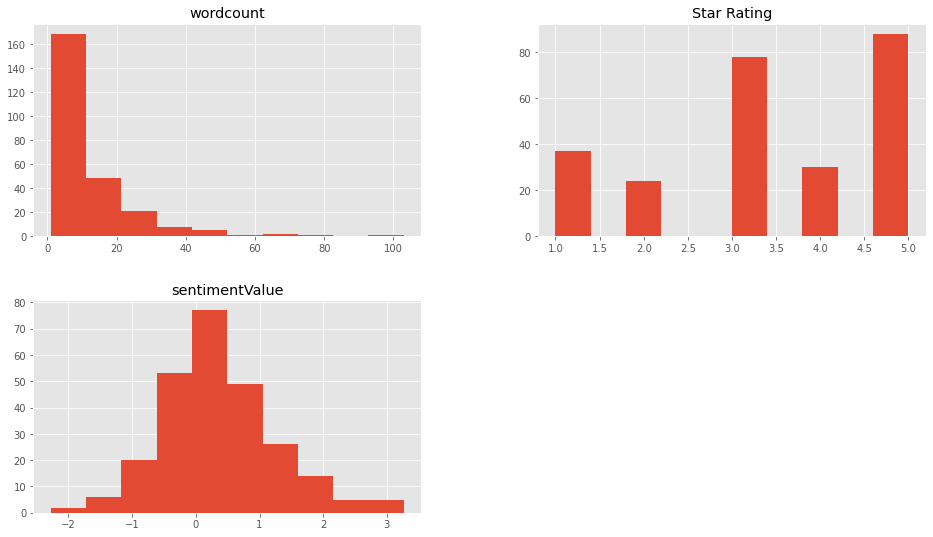

In [8]:
dataframe.hist()
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Solución:</strong>
</div>

In [9]:
# Calculamos las frecuencias de Star Rating
print(dataframe.groupby('Star Rating').size())


Star Rating
1    37
2    24
3    78
4    30
5    88
dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:3717: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
/usr/local/lib/pyt

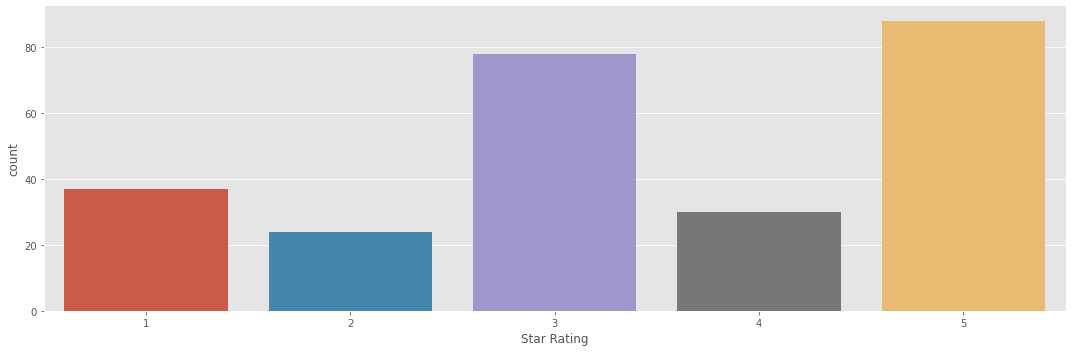

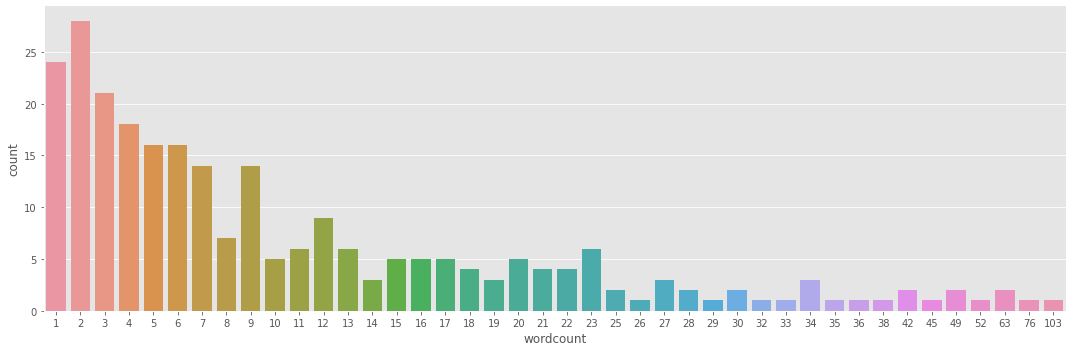

In [10]:
sb.factorplot('Star Rating',data=dataframe,kind="count", aspect=3)
sb.factorplot('wordcount',data=dataframe,kind="count", aspect=3)

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
¿Qué podemos interpretar de las gráficas anteriores? 
    

</div>

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">

Vemos que la distribución de “estrellas” no está balanceada… esto no es bueno. Convendría tener las mismas cantidades en las salidas para no tener resultados “tendenciosos”. 

La gráfica de Valores de Sentimientos se parece bastante a una campana gaussiana (distribución normal) movida levemente hacia la derecha del cero. 

Podemos observar que la mayoría de los comentarios se clasifican como neutros.


Por último la cantidad de palabras se centra sobre todo de 0 a 10.Es decir, la mayoría de las reseñas son bastante cortas.  
U
n análisis extra que se podía hacer es ver la relación entre la variable Star Rating y el número de palabras que se utiliza para realizar una reseña (¿Las reseñas positivas suelen ser más cortas o más largas que las reseñas negativas?¿Solemos expresar nuestra disconformidad siendo parcos de palabras o por el contrario solemos "dar más explicaciones"?   
</div>

### Construcción del modelo
Vamos a construir nuestro kNN. Para ello dividiremos el set de datos en entrenamiento y test y utilizaremos k = 7

In [11]:
# Dividimos en train/test

X = dataframe[['wordcount','sentimentValue']].values
y = dataframe['Star Rating'].values

oversample = SMOTE()
X, y= oversample.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [12]:
# Creamos nuestro modelo
# Elegimos el número de vecinos
n_neighbors = 7

# Llamamos al modelo y lo ajustamos
knn = KNeighborsClassifier(n_neighbors)
knn.fit(X_train, y_train)

print('Accuracy of K-NN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))
print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))

Accuracy of K-NN classifier on training set: 0.94
Accuracy of K-NN classifier on test set: 0.89


In [13]:
# Realizamos las predicciones con predict
pred = knn.predict(X_test)
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))

[[24  0  1  0  0]
 [ 0 25  0  0  0]
 [ 1  1 18  0  0]
 [ 0  0  3 13  1]
 [ 0  0  5  0 18]]
              precision    recall  f1-score   support

           1       0.96      0.96      0.96        25
           2       0.96      1.00      0.98        25
           3       0.67      0.90      0.77        20
           4       1.00      0.76      0.87        17
           5       0.95      0.78      0.86        23

    accuracy                           0.89       110
   macro avg       0.91      0.88      0.89       110
weighted avg       0.91      0.89      0.89       110



### Dibuja las fronteras de decisión
Dibujamos las fronteras de decisión <br>
En este caso hemos llamado al modelo kNN como clf

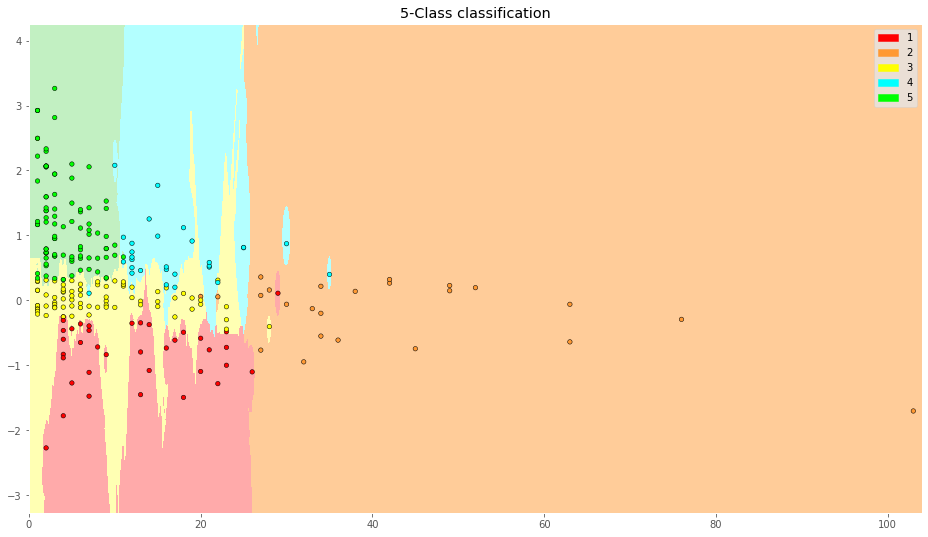

In [14]:
h = .02  # step size in the mesh

X = dataframe[['wordcount','sentimentValue']].values
y = dataframe['Star Rating'].values
# Create color maps
cmap_light = ListedColormap(['#FFAAAA', '#ffcc99', '#ffffb3','#b3ffff','#c2f0c2'])
cmap_bold = ListedColormap(['#FF0000', '#ff9933','#FFFF00','#00ffff','#00FF00'])

# we create an instance of Neighbours Classifier and fit the data.
clf = KNeighborsClassifier(n_neighbors=7, weights='distance')
clf.fit(X, y)

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure()
plt.pcolormesh(xx, yy, Z, cmap=cmap_light)

# Graficamos también los puntos de entrenamiento
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold,
                edgecolor='k', s=20)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
    
patch0 = mpatches.Patch(color='#FF0000', label='1')
patch1 = mpatches.Patch(color='#ff9933', label='2')
patch2 = mpatches.Patch(color='#FFFF00', label='3')
patch3 = mpatches.Patch(color='#00ffff', label='4')
patch4 = mpatches.Patch(color='#00FF00', label='5')
plt.legend(handles=[patch0, patch1, patch2, patch3,patch4])

    
plt.title("5-Class classification")
               

plt.show()

 Viendo la frontera de decisión, ¿qué características podemos intuir de los usuarios que usan y valoran la app?


Podríamos decir “a ojo” según el gráfico anterior que una review de 20 palabras y Sentimiento 1, nos daría una valoración de 4 (zona celeste). <br>
Con estas zonas podemos intuir ciertas características de los usuarios que usan y valoran la app: <br>
- Los usuarios que ponen 1 estrella tienen sentimiento negativo y usan hasta 25 palabras. <br>
- Los usuarios que ponen 2 estrellas dan muchas explicaciones (hasta 100 palabras) y su sentimiento puede variar entre negativo y algo positivo. <br>
- Los usuarios que ponen 3 estrellas son bastante neutrales en sentimientos, puesto que están en torno al cero y usan hasta unas 25 palabras. <br>
- Los usuarios que dan 5 estrellas son bastante positivos (de 0,5 en adelante, aproximadamente) y suelen utilizar pocas palabras (hasta 10).

### Vamos a elegir el mejor valor de K


 En el anterior apartado hemos realizado nuestro modelo con k = 7, es decir con 7 vecinos. 
Para elegir el k más adecuado vamos a ejecutar el algortimo kNN para valores que varían entre 1 y 20. 

([<matplotlib.axis.XTick at 0x7fc84dfe6e90>,
 <a list of 5 Text major ticklabel objects>)

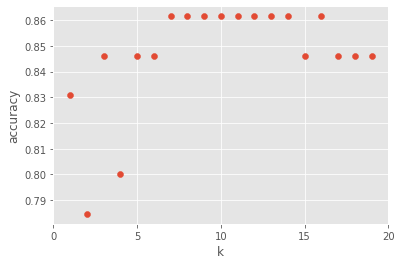

In [ ]:
# Defino el rango de k que voy a probar
k_range = range(1, 20)

# Me guardo los resultados en una lista que voy a llamar scores
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))

# Grafico los resultados para poder visualizar cuál sería el k que me da una mayor accuracy
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])